In [2]:
import climpy.utils.mie_utils as mie
import climpy.utils.aeronet_utils as aeronet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import os
from climpy.utils.plotting_utils import JGR_page_width_inches, save_figure_bundle
from climpy.utils.refractive_index_utils import get_dust_ri
from climpy.utils.stats_utils import get_cdf

__author__ = 'Sergey Osipov <Serega.Osipov@gmail.com>'

"""
https://github.com/SeregaOsipov/ClimPy/wiki/Aerosols-infographic

This is the modified version of aerosols_optical_properties_size_diags.py
Here, I use the airborne dust size distribution to access their contribution to aerosols optical properties and eventually to radiative forcing
"""

'\nhttps://github.com/SeregaOsipov/ClimPy/wiki/Aerosols-infographic\n\nThis is the modified version of aerosols_optical_properties_size_diags.py\nHere, I use the airborne dust size distribution to access their contribution to aerosols optical properties and eventually to radiative forcing\n'

In [149]:
# These are NCAR size distribution measured during cloud seeding research by Duncan Axisa


def get_abha_size_distribution():
    # prep SD aux data
    fp  = '/home/osipovs/Downloads/Abha/ASDprocessed/ASD_bins.csv'
    sd_bins_df = pd.read_csv(fp, header=0, skipinitialspace=True, sep=';')
    sd_bins_df = sd_bins_df[['ASD', 'Mid size']]
    # prep SD data
    fp  = '/home/osipovs/Downloads/Abha/ASDprocessed/RF08_20090811_ASD_no_smooth.csv'
    df = pd.read_csv(fp, header=0, skipinitialspace=True)
    # drop regions contaminated by clouds (cloud=1)
    df = df[df['cloud'] == 0]
    df = df.sort_values('Alt')
    dz = df.Alt.diff()

    # integrate vertically
    sd_columns = [column for column in df.columns if 'ASD' in column]
    # ASD: aerosol conc in each size bin dN/dlogDp (number/cm^3); aerosol size in micrometers
    # ALT: altitude in meters
    column_sd_df = df[sd_columns].multiply(dz*10**2, axis='index')  # number / cm^2
    column_sd_df = column_sd_df.iloc[1:]  # drop first row due to NaN in dz
    if column_sd_df.isnull().values.any():
        raise Exception('NaN values prior to integration could cause faulty results across the size distribution')
    column_sd_df = column_sd_df.sum(axis=0)

    return column_sd_df


def get_riyadh_size_distribution():
    # Riyadh size distributyion
    fp = '/home/osipovs/Downloads/Riyadh/Duncan/20070409_number.txt'
    df = pd.read_csv(fp, header=0, delim_whitespace=True) #, skipinitialspace=True)
    df.rename(columns={'GALT[m]':'Alt'}, inplace=True)
    df = df.sort_values('Alt')
    df = df.dropna()
    dz = df.Alt.diff()

    # integrate vertically
    sd_columns = []
    bin_sizes = []
    for column in df.columns:
        try:
            size = float(column)
            sd_columns += [column, ]
            bin_sizes += [size, ]
        except:
            continue

    # ASD: aerosol conc in each size bin dN/dlogDp (number/cm^3); aerosol size in micrometers
    # ALT: altitude in meters
    column_sd_df = df[sd_columns].multiply(dz*10**2, axis='index')  # number / cm^2
    column_sd_df = column_sd_df.iloc[1:]  # drop first row due to NaN in dz
    if column_sd_df.isnull().values.any():
        raise Exception('NaN values prior to integration could cause faulty results across the size distribution')
    column_sd_df = column_sd_df.sum(axis=0)

    column_sd_df.index = bin_sizes

    return column_sd_df

In [150]:
columnd_sd_df = get_riyadh_size_distribution()

In [154]:
df.columns

Index(['time', '0.0124', '0.0129', '0.01341', '0.01394', '0.0145', '0.01508',
       '0.01568', '0.01631', '0.01696',
       ...
       '34.0', '36.5', '39.5', '42.5', '45.5', 'GLAT', 'GLON', 'Alt', 'ATN[C]',
       'DPN[C]'],
      dtype='object', length=123)

Text(0, 0.5, 'dN/dlogDp, ($\\mathrm{cm^{-2}}$)')

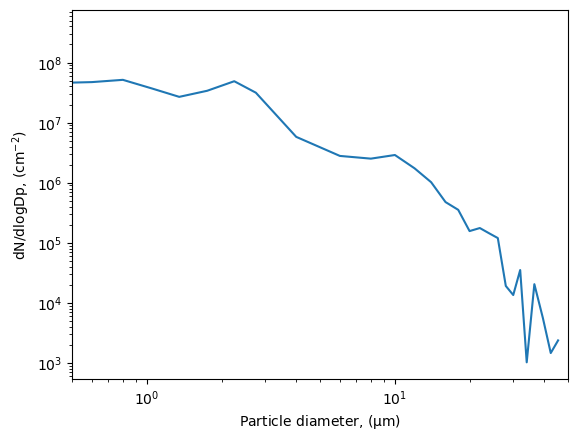

In [151]:
ax = column_sd_df.plot(logy=True, logx=True)
ax.set_xlim([0.5, 50])
ax.set_xlabel('Particle diameter, ($\mathrm{\mu m}$)')
ax.set_ylabel('dN/dlogDp, ($\mathrm{cm^{-2}}$)')

In [153]:
# get dust RI for Saudi
ri_vo = get_dust_ri()
# and size distribution
# Three cases:
# 1. Aeronet SD at KAUST
csv_fp = './examples/aerosols_infographic/size_distribution_data/aeronet.csv'
panel_annotation_lr = 'Aeronet station @ KAUST\n2014-2019 mean'
file_name_postfix = 'KAUST Aeronet'
# 2. Deposition sample (sieved)
# csv_fp = '../ClimPy/examples/aerosols_infographic/size_distribution_data/sieved.csv'
# panel_annotation_lr = 'Deposition samples @ KAUST\nSieved, 2016-2018 mean'
# file_name_postfix = 'KAUST sieved deposition'
# 3. Deposition sample (unsieved)
# csv_fp = '../ClimPy/examples/aerosols_infographic/size_distribution_data/unsieved.csv'
# panel_annotation_lr = 'Deposition samples @ KAUST\nUnsieved, 2016-2018 mean'
# file_name_postfix = 'KAUST unsieved deposition'
#NOTE: deposition samples were normalized somehow
sd_df = pd.read_csv(csv_fp, usecols=[1, 2])

FileNotFoundError: [Errno 2] No such file or directory: './examples/aerosols_infographic/size_distribution_data/aeronet.csv'

In [ ]:

wl_index = 0

# Compute Mie extinction coefficients
r_data = sd_df['radii'].to_numpy()
mie_vo = mie.get_mie_efficiencies(ri_vo['ri'], r_data, ri_vo['wl'])

cross_section_area_transform = 3/4 * r_data**-1
od = np.trapz(mie_vo['qext'] * sd_df['dVdlnr'].to_numpy() * cross_section_area_transform, np.log(r_data), axis=1)

# compute the CDFs for volume/mass and AOD
volume_cdf = get_cdf(sd_df['dVdlnr'], np.log(r_data))
area_cdf = get_cdf(sd_df['dVdlnr'] * cross_section_area_transform, np.log(r_data))
aod_cdf = get_cdf(mie_vo['qext'][wl_index] * sd_df['dVdlnr'] * cross_section_area_transform, np.log(r_data))

# radius setup
x_coord = sd_df['radii']
x_coord_label = 'Radius'
# diameter setup
x_coord = 2*sd_df['radii']
x_coord_label = 'Diameter'

# DO THE PLOTTING
fig = plt.figure(constrained_layout=True, figsize=(JGR_page_width_inches() * 1.15, JGR_page_width_inches()))
# fig = plt.figure(figsize=(get_JGR_full_page_width_inches()*1., get_JGR_full_page_width_inches()))
gs = fig.add_gridspec(ncols=2, nrows=4, width_ratios=[1, 3], height_ratios=[3, 10, 10, 10])

# HEADER
ax_text = fig.add_subplot(gs[0, :])
ax_text.annotate(r'Aerosols: mass vs optical depth', (0.5, 0.5),
                 fontsize='xx-large',
                 xycoords='axes fraction', va='center', ha='center')
ax_text.axis('off')

ax_text = fig.add_subplot(gs[1, 0])
ax_text.annotate('Area under the curves\n\nrepresents volume (mass) and \ncross section (attenuation of light)',
                 (0.5, 0.5),
                 xycoords='axes fraction', va='center', ha='center')
ax_text.axis('off')

ax_text = fig.add_subplot(gs[2, 0])
ax_text.annotate('Extinction efficiency of each particle.\n\n$\lambda$ = {:3.0f} nm'.format(ri_vo['wl'][wl_index]*10**3), (0.5, 0.5),
                 xycoords='axes fraction', va='center', ha='center')
ax_text.axis('off')

ax_text = fig.add_subplot(gs[3, 0])
ax_text.annotate('Contribution of particles that are <= r.\n\nNormalized to 1.', (0.5, 0.5),
                 xycoords='axes fraction', va='center', ha='center')
ax_text.axis('off')

# the plots itself
ax = fig.add_subplot(gs[1, 1])
plt.sca(ax)
plt.plot(x_coord, sd_df['dVdlnr'], '-o', label='Volume')
plt.xscale('log')
# plt.xlabel('{}, ($\mu m$)'.format(x_coord_label))
plt.ylabel('dV/dlnr [$\mu m^3$ $\mu m^{-2}$]')
plt.title('Size distributions')
# plt.legend(loc='upper left')

color = 'tab:orange'
ax2 = ax.twinx()
plt.sca(ax2)
plt.xscale('log')
plt.tick_params(axis='y', labelcolor=color)
plt.plot(x_coord, sd_df['dVdlnr']*3/4*r_data**-1, '-o', color=color, label='Area')
plt.ylabel('dA/dlnr [$\mu m^2$ $\mu m^{-2}$]', color=color)
# plt.legend(loc='upper right')

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc='upper right')

# ax = fig.add_subplot(gs[2, 1])
# plt.sca(ax)
# plt.plot(ri_vo['wl'], np.real(ri_vo['data']), '-o')
# plt.xlabel('Wavelength, ($\mu m$)')
# plt.ylabel('Re(refractive index)')
#
# color = 'tab:gray'
# ax2 = ax.twinx()
# ax2.tick_params(axis='y', labelcolor=color)
# plt.plot(ri_vo['wl'], np.imag(ri_vo['data']), '-o', color=color)
# plt.ylabel('Im(refractive index)', color=color)
# plt.title('Refractive index')

ax = fig.add_subplot(gs[2, 1])
plt.sca(ax)
plt.plot(x_coord, mie_vo['qext'][wl_index], '-o')  # x_coord is sample the same as 2*mie_vo['r_data']
plt.xscale('log')
# plt.xlabel('{}, ($\mu m$)'.format(x_coord_label))
plt.ylabel('Extinction coefficient, ()')
plt.title('Mie $Q_{ext}$')

ax = fig.add_subplot(gs[3, 1])
plt.sca(ax)
plt.grid()
plt.plot(x_coord, volume_cdf/volume_cdf[-1], '-o', label='Volume')
plt.plot(x_coord, area_cdf/area_cdf[-1], '-o', label='Area')
plt.plot(x_coord, aod_cdf/aod_cdf[-1], '-o', label='AOD')
plt.xscale('log')
plt.xlabel('{}, ($\mu m$)'.format(x_coord_label))
plt.ylabel('CDF, ()')
plt.title('Cumulative distribution functions')  #  \n normalized to 1
plt.legend()

# text at the bottom
plt.annotate(panel_annotation_lr, (0.99, 0.015), fontsize='x-small', xycoords='figure fraction', va='center', ha='right')
url = 'https://github.com/SeregaOsipov/ClimPy/wiki/Aerosols-infographic'
# have to create new axis because of the bug in constrained_layout
ax_b = plt.axes((0.01, 0.015, 0.5, 0.05), facecolor='w')
ax_b.annotate('{}'.format(url), (0.01, 0.015), fontsize='x-small', xycoords='figure fraction', va='center', ha='left')
ax_b.axis('off')
# plt.tight_layout()

save_figure_bundle(os.path.expanduser('~') + '/Pictures/Papers/infographics/aerosols/{}/'.format(x_coord_label),
                   'Aerosols size distribution and optical properties, {}, wl={}'.format(file_name_postfix, ri_vo['wl'][wl_index]))
save_figure_bundle(get_root_storage_path_on_hpc() + '/Pictures/Papers/infographics/aerosols/{}/'.format(x_coord_label),
                   'Aerosols size distribution and optical properties, {}, wl={}'.format(file_name_postfix, ri_vo['wl'][wl_index]))
